### Data loading and shuffeling

This code block performs two main actions. First, it loads a car dataset from a CSV file and randomly shuffles all the rows to ensure the order of data does not influence analysis. Second, it simplifies the car model data by grouping rare models into a single 'other' category. Specifically, it identifies the 100 most frequent car models, keeps their names unchanged, and changes the name of any less frequent model to 'other', thereby creating a cleaner and more manageable categorical variable for models and analysis.

In [1]:
import pandas as pd

# Shuffeling
df = pd.read_csv("CarsData_cleaned.csv", sep=";")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Grouping
top_models = df['model'].value_counts().nlargest(100).index
df['model_grouped'] = df['model'].apply(lambda x: x if x in top_models else 'other')

df.head()

,model,year,price,transmission,mileage,fuelType,engineSize,Manufacturer,model_grouped
0,I30,2017,11500,Manual,11276,Petrol,1.4,hyundai,I30
1,Golf,2016,13991,Manual,20902,Petrol,1.4,volkswagen,Golf
2,C Class,2016,16750,Automatic,24909,Diesel,1.6,mercedes benz,C Class
3,Corsa,2020,16749,Manual,115,Petrol,1.2,opel,Corsa
4,GLA Class,2017,17889,Semi-Auto,42941,Diesel,2.1,mercedes benz,GLA Class


### Data preparing
Target Variable (y): It defines y as the price column from the dataset. This is the variable the model will be trained to predict.

Feature Matrix (X): It creates X, which is a DataFrame containing the predictor variables. It selects the columns for the car's grouped model, year, mileage, fuel type, transmission, engine size, and manufacturer.

Encoding Categorical Data: Finally, it uses pd.get_dummies() to convert all text-based categorical variables (like model_grouped, fuelType, etc.) into numerical binary (0/1) columns.

In [2]:
y = df['price']
X = df[['model_grouped', 'year','mileage','fuelType','transmission','engineSize','Manufacturer']]
# Removes one binary column from each category to prevent redundant information and improve the model's calculations.
X = pd.get_dummies(X, drop_first=True)

### Simple visualization
This graph shows the ten car manufacturers with the highest average price in the dataset. The average price for each brand is clearly displayed for easy comparison.

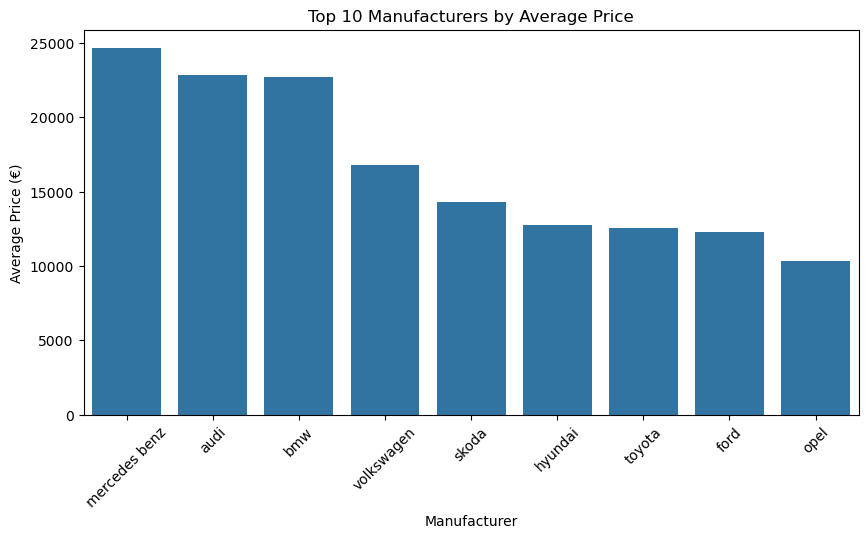

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
top_manufacturers = df.groupby('Manufacturer')['price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_manufacturers.index, y=top_manufacturers.values)
plt.xticks(rotation=45)
plt.title("Top 10 Manufacturers by Average Price")
plt.ylabel("Average Price (€)")
plt.xlabel("Manufacturer")
plt.show()

### Test and train data
We split the data to training and test data. Training data is 80% of the data, which we use to teach the models and 20% is used to evaluete the model's performance.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## First Model - Random Forest
Random Forest Regressor model, we used parameters:
1) n_ estimators=500 - creates 500 individual decision trees, 500 trees good accuracy witouh being too slow
2) max_depth=25 - maximum depth of each decision tree, used to avoid overfitting, because we have over 90 000 cars. 25 trees can capture complex price patterns
3) min_samples_split=10 - minimum samples required to split a node
4) min_samples_leaf=5 - minimum samples required in a leaf node, meaning each leaf must have at least 5 cars
5) random_state=42 - makes the random selection of features and samples reproducible

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, max_depth=25, min_samples_split=10, min_samples_leaf=5, random_state=42)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=500, random_state=42)

## Second Model - LightGBM (Light Gradient Boosting Machine) Regressor
Higly efficient and powerful gradient boosting framework, which handles well big data and is also fast.
We created a LightGBM model that is optimized for fast training and high accuracy with specific parameters.

1) n_estimators=2000 - high limit, early stopping will stop training if there is no improvement for 100 consecutive rounds and this prevents overfitting by not training longer. Also saves time.
2) learning_rate=0.05 - balanced between speed and accuracy
3) num_leaves=64 - enpugh complexity without overfitting
4) max_depth=-1 - no tree depth limit, maximum CPU utilization for speed
5) min_data_in_leaf=30	- prevents overfitting
6) subsample=0.8 - randomness to prevent overfitting
7) colsample_bytree=0.8 - 80% features used for each tree, more diverse trees
8) random_state = 42
9) n_jobs = -1 - using all CPU cores

In [6]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score

# Trains the model while monitoring performance on test data to prevent overfitting and optimize training time.
lgb_model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    min_data_in_leaf=30,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Early stopping for 100 consecutive rounds
callbacks = [lgb.early_stopping(stopping_rounds=100)]

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    callbacks=callbacks
)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 78169, number of used features: 116
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 16764.079584
Training until validation scores don't improve for 100 rounds
Ea

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, min_data_in_leaf=30,
              n_estimators=2000, n_jobs=-1, num_leaves=64, random_state=42,
              subsample=0.8)

In [7]:
y_pred = lgb_model.predict(X_test)
print("LightGBM")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

y_pred = rf.predict(X_test)

print("")
print("Random Forest")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
LightGBM
Mean Absolute Error (MAE): 1345.028447098671
R2 score: 0.9406244939947213

Random Forest
Mean Absolute Error (MAE): 1484.3747240736072
R2 score: 0.927737869848359


### Anlysis
MAE:
LightGBM predictions are €1,345 away from actual prices
Random Forest predictions are €1,484 away on average
Difference: €139.34 - LightGBM is €139 more accurate per prediction
<br>
<br>
R2 score:
LightGBM R²: 0.9406 - The model explains 94.06% of price variance
Random Forest R²: 0.9277 - Explains 92.77% of price variance
Difference: 1.29% - LightGBM explains 1.29% more variance
<br>
<br>
While both models deliver accurate and highly similar predictive power, LightGBM consistently outperforms Random Forest across both metrics. This comes from its sequential error-correction approach (gradient boosting), combined with built-in regularization techniques like early stopping and feature subsampling—which together prevent overfitting and enable more refined decision splits.
<br>
<br>
These result show taht both models are really accurate when predicting used car prices and there is minimamal performance gap.

### Models error between different car price segments

In [18]:
# Analyze performance across different price segments
y_test_series = pd.Series(y_test.values, index=X_test.index)
price_segments = pd.qcut(y_test_series, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

performance_by_segment = pd.DataFrame({
    'True_Price': y_test_series,
    'Pred_LGB': y_pred_lgb,
    'Pred_RF': y_pred_rf,
    'Segment': price_segments
})

segment_stats = performance_by_segment.groupby('Segment').agg({
    'True_Price': 'mean',
    'Pred_LGB': 'mean',
    'Pred_RF': 'mean'
}).round(2)

segment_stats['LGB_Error_%'] = ((segment_stats['Pred_LGB'] - segment_stats['True_Price']) / segment_stats['True_Price'] * 100).round(2)
segment_stats['RF_Error_%'] = ((segment_stats['Pred_RF'] - segment_stats['True_Price']) / segment_stats['True_Price'] * 100).round(2)

print(segment_stats)

           True_Price  Pred_LGB   Pred_RF  LGB_Error_%  RF_Error_%
Segment                                                           
Very Low      7305.06   7560.55   7647.10         3.50        4.68
Low          10905.99  11062.53  11150.25         1.44        2.24
Medium       14525.42  14582.91  14644.80         0.40        0.82
High         19429.80  19505.96  19455.18         0.39        0.13
Very High    31917.47  31156.22  31001.65        -2.39       -2.87


C:\Users\kontse\AppData\Local\Temp\ipykernel_9152\2557996784.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = performance_by_segment.groupby('Segment').agg({


### Graphs that show price prediction errors

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


C:\Users\kontse\AppData\Local\Temp\ipykernel_9152\2789142618.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\kontse\AppData\Local\Temp\ipykernel_9152\2789142618.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


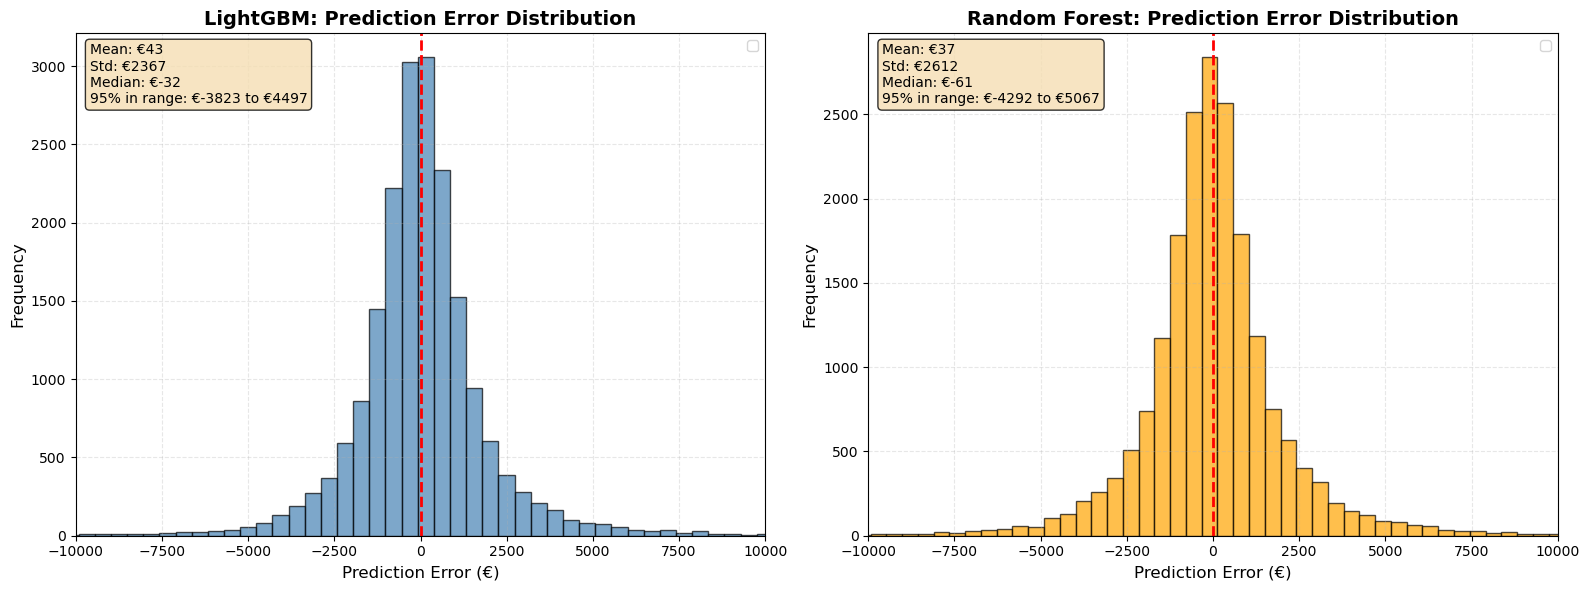

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions using both trained models
y_pred_lgb = lgb_model.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Calculate prediction errors
residuals_lgb = y_test - y_pred_lgb
residuals_rf = y_test - y_pred_rf

# Two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LightGBM
# Create histogram with 300 bins for detailed error distribution visualization
ax1.hist(residuals_lgb, bins=300, alpha=0.7, edgecolor='black', color='steelblue')
# Add red dashed line at zero
ax1.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Prediction Error (€)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('LightGBM: Prediction Error Distribution', fontsize=14, fontweight='bold')
# Limit x-axis to show errors between -€10,000 and €10,000 for better visualization
ax1.set_xlim(-10000, 10000)
ax1.legend()
ax1.grid(alpha=0.3, linestyle='--')

# Add statistical summary
stats_text = (f'Mean: €{residuals_lgb.mean():.0f}\n'
              f'Std: €{residuals_lgb.std():.0f}\n'
              f'Median: €{np.median(residuals_lgb):.0f}\n'
              f'95% in range: €{np.percentile(residuals_lgb, 2.5):.0f} to €{np.percentile(residuals_lgb, 97.5):.0f}')
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)

# Random Forest
# Create histogram with 300 bins for detailed error distribution visualization
ax2.hist(residuals_rf, bins=300, alpha=0.7, edgecolor='black', color='orange')
# Add red dashed line at zero
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Prediction Error (€)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Random Forest: Prediction Error Distribution', fontsize=14, fontweight='bold')
# Limit x-axis to show errors between -€10,000 and €10,000 for better visualization
ax2.set_xlim(-10000, 10000)
ax2.legend()
ax2.grid(alpha=0.3, linestyle='--')

# Add statistical summary
stats_text = (f'Mean: €{residuals_rf.mean():.0f}\n'
              f'Std: €{residuals_rf.std():.0f}\n'
              f'Median: €{np.median(residuals_rf):.0f}\n'
              f'95% in range: €{np.percentile(residuals_rf, 2.5):.0f} to €{np.percentile(residuals_rf, 97.5):.0f}')
ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

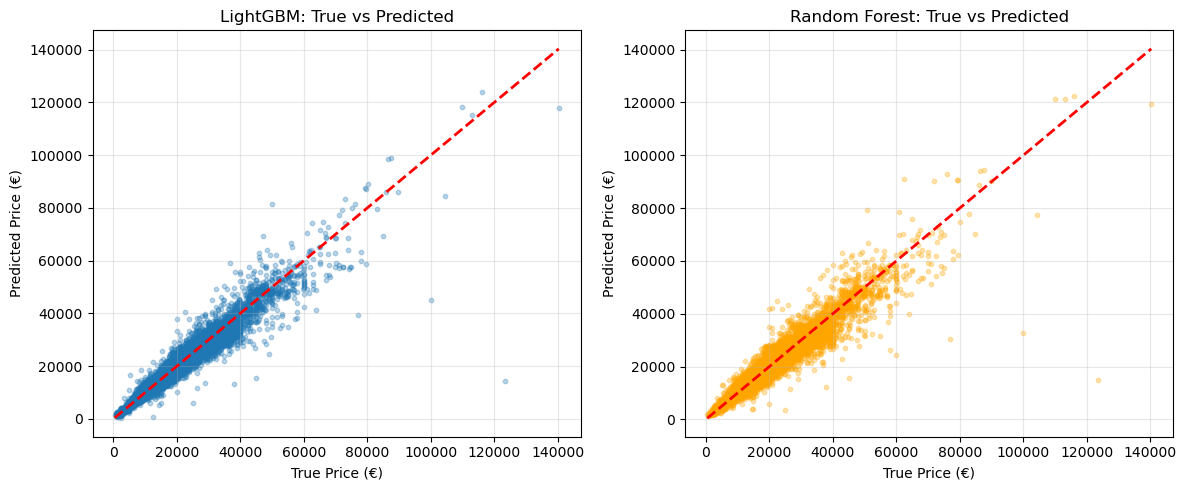

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lgb, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Price (€)')
plt.ylabel('Predicted Price (€)')
plt.title('LightGBM: True vs Predicted')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.3, s=10, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Price (€)')
plt.ylabel('Predicted Price (€)')
plt.title('Random Forest: True vs Predicted')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Top 20 most important features for each model which determine price

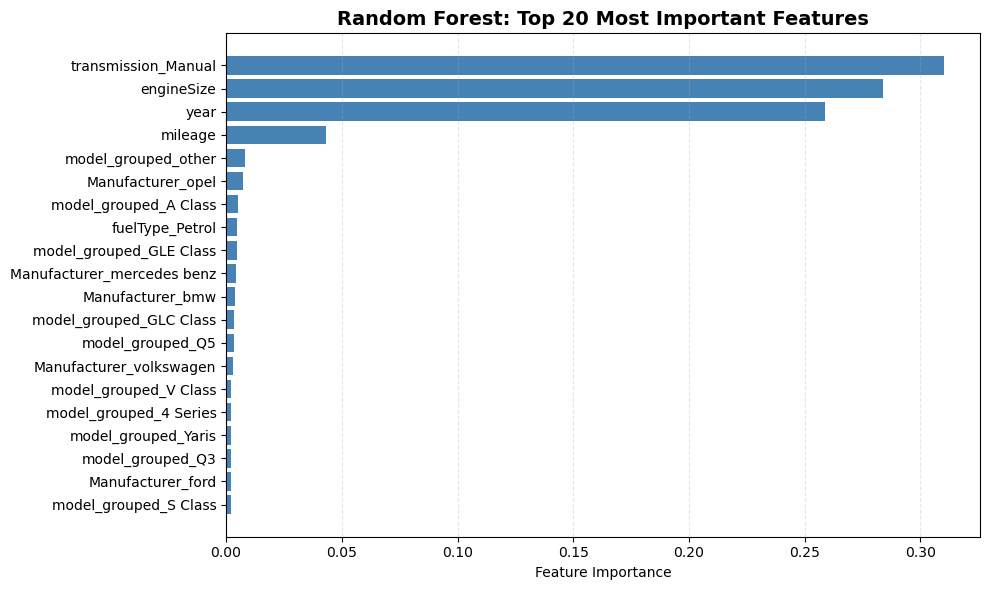

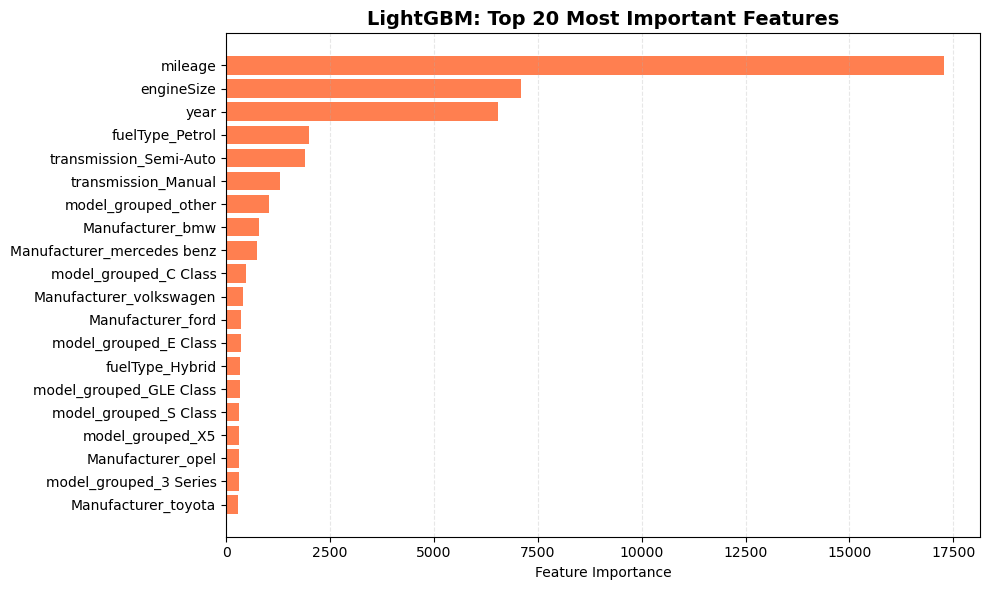

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances for both models
rf_importances = rf.feature_importances_
lgb_importances = lgb_model.feature_importances_
features = X.columns

# Sort indices for both models
rf_indices = np.argsort(rf_importances)[::-1]
lgb_indices = np.argsort(lgb_importances)[::-1]

top_n = 20

# Random Forest features
plt.figure(figsize=(10,6))
plt.barh(range(top_n), rf_importances[rf_indices[:top_n]], align="center", color='steelblue')
plt.yticks(range(top_n), [features[i] for i in rf_indices[:top_n]])
plt.xlabel("Feature Importance")
plt.title("Random Forest: Top 20 Most Important Features", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# LightGBM Top 20 features
plt.figure(figsize=(10,6))
plt.barh(range(top_n), lgb_importances[lgb_indices[:top_n]], align="center", color='coral')
plt.yticks(range(top_n), [features[i] for i in lgb_indices[:top_n]])
plt.xlabel("Feature Importance")
plt.title("LightGBM: Top 20 Most Important Features", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

There is a clear differneces how two models pioritize features. Random Forest gives highest importance to transmission_Manual and LightGBM places mileage as the most critical factor. Both models consistently value engineSize and year as top predictors, confirming these as fundamental price drivers. 

### Price prediction models with specs, WE ALSO HAVE PROGRAM FOR THIS IN THE DIRECTORY

In [21]:
uus_auto = pd.DataFrame({
    'model_grouped':['5 Series'],
    'year':[2017],
    'mileage':[200000],
    'fuelType':['Diesel'],
    'transmission':['Automatic'],
    'engineSize':[2.0],
    'Manufacturer':['bmw']
})

uus_auto = pd.get_dummies(uus_auto)
uus_auto = uus_auto.reindex(columns=X.columns, fill_value=0)

hind = rf.predict(uus_auto)
print("Predicted price:", hind[0])

Ennustatud hind: 13272.755514792254


In [23]:
hind = lgb_model.predict(uus_auto)
print("Predicted price:", hind[0])

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Predicted price: 12821.110831462562


### Saving models

In [27]:
import joblib

joblib.dump(rf, "models/randomForest.pkl")
joblib.dump(lgb_model, "models/lgbModel.pkl")
joblib.dump(X.columns, "models/X_columns.pkl")
joblib.dump(df["model_grouped"].unique().tolist(), "models/model_grouped_values.pkl")
joblib.dump(df["fuelType"].unique().tolist(), "models/fuelType_values.pkl")
joblib.dump(df["transmission"].unique().tolist(), "models/transmission_values.pkl")
joblib.dump(df["engineSize"].unique().tolist(), "models/engineSize_values.pkl")
joblib.dump(df["Manufacturer"].unique().tolist(), "models/manufacturer_values.pkl")

['models/manufacturer_values.pkl']